## Выбор датасета и метрик

Я выбрала датасет diamond online marketplace, который содержит различные характеристики для 6400 дагоценных камней.  
Характеристики:  
* Shape - форма огранки камня  
* Cut - качество огранки
* Color - цвет камня
* Clarity - чистота камня
* Carat Weight - вес камня 
* Length/Width Ratio — Соотношение длины к ширине камня  
* Depth % — Глубина камня в процентах от его ширины  
* Table % — Ширина таблицы (верхней плоскости камня) в процентах от ширины  
* Polish — Качество полировки  
* Symmetry — Симметрия огранки  
* Girdle — Толщина рундиста  
* Culet — Размер калетты  
* Length — Длина камня в миллиметрах  
* Width — Ширина камня в миллиметрах  
* Height — Высота камня в миллиметрах  
* Price — Цена камня в условных единицах  
* Type — Тип камня( lab grown or natural)
* Fluorescence — Наличие и интенсивность флуоресценции  


## KNN алгоритм

Загружаем необходимые библиотеки

In [90]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

### KNN классификатор

Постановка задачи: Классификация по типу камня.  
Необходимо научится предсказывать является ли камень лабораторно выращенным или натуральным на основе характеристик. Поскольку на рынке камней существует большая разница в восприятии и цене искусственных и натуральных камней. Многие недобросовестные продавцы пытаются "втюхать" выращенный в лаборатории камень по цене натурального. Модель должна решать проблему мошенничества и подтвепжать подлинность происхождения камней.

Загружаем данные датасета

In [91]:
# Чтение данных
data = pd.read_csv('diamonds.csv')

# Переименование колонок
data.columns = [
    "Shape", "Cut", "Color", "Clarity",
    "Carat_Weight", "Length_Width_Ratio", "Depth",
    "Table", "Polish", "Symmetry", "Girdle",
    "Culet", "Length", "Width", "Height",
    "Price", "Type", "Fluorescence"
]


# Удаление ненужных колонок
data = data.drop(["Shape", "Price", "Girdle", "Culet", "Length", "Width", "Height"], axis=1)

data.head()

,Cut,Color,Clarity,Carat_Weight,Length_Width_Ratio,Depth,Table,Polish,Symmetry,Type,Fluorescence
0,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,GIA Lab-Grown,NaN
1,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,GIA Lab-Grown,NaN
2,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,GIA Lab-Grown,NaN
3,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,GIA,Faint
4,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,GIA,NaN


<Axes: >

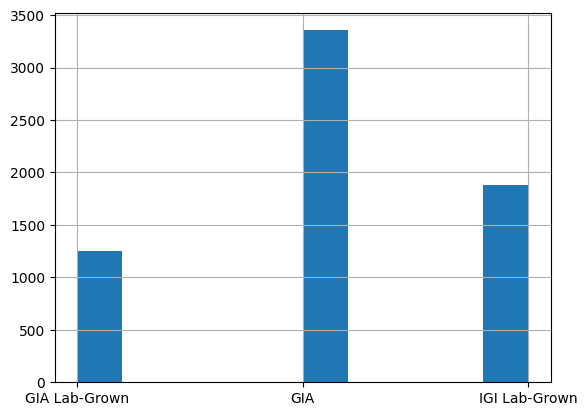

In [92]:
data.Type.hist()

Подготавливаем данные для обучения

In [93]:
# Кодирование целевой переменной
label_encoder = LabelEncoder()
data['Type'] = label_encoder.fit_transform(data['Type'])

# Определение категориальных и числовых признаков
categorical_features = ["Cut", "Color", "Clarity", "Polish", "Symmetry", "Fluorescence"]
numerical_features = ["Carat_Weight", "Length_Width_Ratio", "Depth", "Table"]


# Разделение данных на признаки и целевую переменную
X = data.drop('Type', axis=1)
y = data['Type']

# Определение препроцессора с обработкой пропущенных значений
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним для числовых данных
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение модой для категориальных данных
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ]
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (5188, 10), Размер тестовой выборки: (1297, 10)


Применим встроенный KNN для классификации

In [94]:
# Пайплайн для KNN
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Бейзлайн
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Бейзлайн:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")


Бейзлайн:
Accuracy: 0.8628
F1-Score: 0.8635


Подберем гиперпараметры для улучшения бейзлайна, сначала добавим новые признаки

In [95]:
# Создание новых признаков
data['Carat_Depth_Ratio'] = data['Carat_Weight'] / data['Depth']
data['Table_Length_Width_Ratio'] = data['Table'] / data['Length_Width_Ratio']

# Кодирование целевой переменной
label_encoder = LabelEncoder()
data['Type'] = label_encoder.fit_transform(data['Type'])


# Определение категориальных и числовых признаков
categorical_features = ["Cut", "Color", "Clarity", "Polish", "Symmetry", "Fluorescence"]
numerical_features = ["Carat_Weight", "Length_Width_Ratio", "Depth", "Table", "Carat_Depth_Ratio", "Table_Length_Width_Ratio"]

X = data.drop('Type', axis=1)
y = data['Type']

# Определение препроцессора
preprocessor_best = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ]
)

# Преобразование данных с использованием препроцессора
X_preprocessed_best = preprocessor_best.fit_transform(X)

# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed_best, y)

# Разделение данных на обучающую и тестовую выборки
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [101]:
# Пайплайн для KNN
pipeline = Pipeline(steps=[
    ('knn', KNeighborsClassifier())
])

# Подбор гиперпараметров
param_grid = {
    'knn__n_neighbors': range(1, 101, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_best, y_train_best)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")



Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Лучшие параметры: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}


Посмотрим результаты улучшенной модели

In [102]:
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_best)

accuracy_best = accuracy_score(y_test_best, y_pred_best)
f1_best = f1_score(y_test_best, y_pred_best, average='weighted')

print("Улучшенный бейзлайн:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_best, y_pred_best))

Улучшенный бейзлайн:
Accuracy: 0.9240
F1-Score: 0.9243

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       671
           1       0.90      0.92      0.91       671
           2       0.90      0.91      0.91       671

    accuracy                           0.92      2013
   macro avg       0.93      0.92      0.92      2013
weighted avg       0.93      0.92      0.92      2013



реализуем собственный алгоритм

In [103]:
# Реализация Custom KNN
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class CustomKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.array(y)

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# Преобразуем данные с использованием пайплайна (только препроцессор)
# Преобразование данных через препроцессор
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

assert not np.isnan(X_train_preprocessed).any(), "NaN values found in X_train_preprocessed"
assert not np.isnan(X_test_preprocessed).any(), "NaN values found in X_test_preprocessed"


# Инициализация Custom KNN
custom_knn = CustomKNN(k=best_params['knn__n_neighbors'])
custom_knn.fit(X_train_preprocessed, y_train)


Результаты и метрики

In [105]:
y_pred_custom = custom_knn.predict(X_test_preprocessed)

accuracy_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average='weighted')

print("Реализация Custom KNN:")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"F1-Score: {f1_custom:.4f}")

Реализация Custom KNN:
Accuracy: 0.8743
F1-Score: 0.8748


сравним все результаты

In [106]:
print("Сравнение результатов:")
print(f"Бейзлайн Accuracy: {accuracy:.4f}, Улучшенный Accuracy: {accuracy_best:.4f}, Custom KNN Accuracy: {accuracy_custom:.4f}")
print(f"Бейзлайн F1-Score: {f1:.4f}, Улучшенный F1-Score: {f1_best:.4f}, Custom KNN F1-Score: {f1_custom:.4f}")

Сравнение результатов:
Бейзлайн Accuracy: 0.8628, Улучшенный Accuracy: 0.9240, Custom KNN Accuracy: 0.8743
Бейзлайн F1-Score: 0.8635, Улучшенный F1-Score: 0.9243, Custom KNN F1-Score: 0.8748


### KNN регрессия

Постановка задачи: Прогноз цены камня.  
На рынке драгоценных камней оценка стоимости часто зависит от экспертов и может быть субъективной. Модель для прогнозирования цены на основе характеристик камня (включая форму, вес, цвет, чистоту и т.д.) позволит автоматизировать процесс и сделать его более объективным. Это экономит время и снижает вероятность ошибок при оценке.

Загрузим необходимые библиотеки

In [110]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE

Подготовими датасет

In [130]:
# Чтение данных
data = pd.read_csv('diamonds.csv')

# Переименование колонок
data.columns = [
    "Shape", "Cut", "Color", "Clarity",
    "Carat_Weight", "Length_Width_Ratio", "Depth",
    "Table", "Polish", "Symmetry", "Girdle",
    "Culet", "Length", "Width", "Height",
    "Price", "Type", "Fluorescence"
]

# Удаление ненужных колонок
data = data.drop(["Shape", "Girdle", "Culet", "Length", "Width", "Height"], axis=1)

data.head()

,Cut,Color,Clarity,Carat_Weight,Length_Width_Ratio,Depth,Table,Polish,Symmetry,Price,Type,Fluorescence
0,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,2640,GIA Lab-Grown,NaN
1,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,1070,GIA Lab-Grown,NaN
2,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,1070,GIA Lab-Grown,NaN
3,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,7110,GIA,Faint
4,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,3050,GIA,NaN


<Axes: >

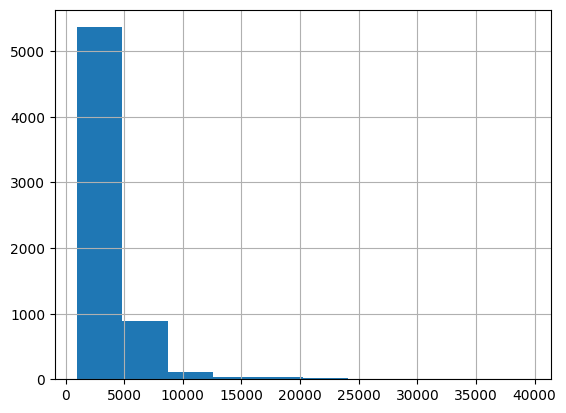

In [131]:
data.Price.hist()

Как мы можем заметить из графика, распределение значений стоимости камней не является равномерным и может повлиять на оценку работы модели. Применим квадратный корень ко всем значениям, чтобы сгладить их и уменьшает риск появления неккоретных оценок

<Axes: >

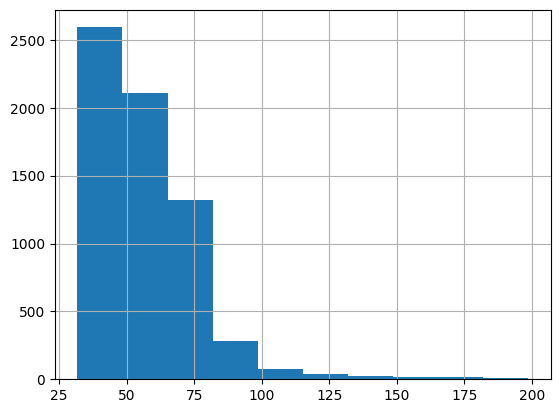

In [135]:
data['Price_mid'] =  np.sqrt(data['Price'])
data.Price_mid.hist()

подготавливаем данные для обучения

In [136]:
# Определение категориальных и числовых признаков
categorical_features = ["Cut", "Color", "Clarity", "Polish", "Symmetry", "Fluorescence"]
numerical_features = ["Carat_Weight", "Length_Width_Ratio", "Depth", "Table"]

# Разделение данных на признаки и целевую переменную
X = data.drop('Price_mid', axis=1)  # Прогнозируемая переменная — Price
y = data['Price_mid']

# Определение препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), 
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ]
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Обучаем модель

In [137]:

# Базовая модель KNN для регрессии
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_preprocessed, y_train)
y_pred = knn.predict(X_test_preprocessed)

# Оценка модели
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

print("Бейзлайн метрики:")
mae, mse, r2 = evaluate_model(y_test, y_pred)
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")


Бейзлайн метрики:
MAE: 5.6427, MSE: 121.8248, R²: 0.7225


Подберем гиперпараметры для улучшения

In [138]:
# Подбор гиперпараметров
param_grid = {"n_neighbors": range(1, 31)}
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
)
grid_search.fit(X_train_preprocessed, y_train)

# Лучшие параметры
best_k = grid_search.best_params_["n_neighbors"]
print(f"Лучший k: {best_k}")

# Оптимизированная модель
knn_optimized = KNeighborsRegressor(n_neighbors=best_k)
knn_optimized.fit(X_train_preprocessed, y_train)
y_pred_optimized = knn_optimized.predict(X_test_preprocessed)

print("\nОптимизированные метрики:")
mae_opt, mse_opt, r2_opt = evaluate_model(y_test, y_pred_optimized)
print(f"MAE: {mae_opt:.4f}, MSE: {mse_opt:.4f}, R²: {r2_opt:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучший k: 5

Оптимизированные метрики:
MAE: 5.6427, MSE: 121.8248, R²: 0.7225


Реализуем собственный алгоритм

In [139]:
# Реализация Custom KNN
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class CustomKNNRegressor:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.array(y)

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return np.mean(k_nearest_labels)

# Custom KNN для прогноза цены
custom_knn = CustomKNNRegressor(k=best_k)
custom_knn.fit(X_train_preprocessed, y_train)
y_pred_custom = custom_knn.predict(X_test_preprocessed)

mae_custom, mse_custom, r2_custom = evaluate_model(y_test, y_pred_custom)

print("\nCustom KNN метрики:")
print(f"MAE: {mae_custom:.4f}, MSE: {mse_custom:.4f}, R²: {r2_custom:.4f}")



Custom KNN метрики:
MAE: 5.6422, MSE: 121.8234, R²: 0.7225


Сравним результаты

In [140]:
# Сравнение результатов
print("\nСравнение результатов:")
print(f"Бейзлайн MAE: {mae:.4f}, Оптимизированный MAE: {mae_opt:.4f}, Custom KNN MAE: {mae_custom:.4f}")
print(f"Бейзлайн MSE: {mse:.4f}, Оптимизированный MSE: {mse_opt:.4f}, Custom KNN MSE: {mse_custom:.4f}")
print(f"Бейзлайн R²: {r2:.4f}, Оптимизированный R²: {r2_opt:.4f}, Custom KNN R²: {r2_custom:.4f}")


Сравнение результатов:
Бейзлайн MAE: 5.6427, Оптимизированный MAE: 5.6427, Custom KNN MAE: 5.6422
Бейзлайн MSE: 121.8248, Оптимизированный MSE: 121.8248, Custom KNN MSE: 121.8234
Бейзлайн R²: 0.7225, Оптимизированный R²: 0.7225, Custom KNN R²: 0.7225


## Линейные модели

### Классификация

Загрузим необходимые библиотеки

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.special import expit
from collections import Counter
from imblearn.over_sampling import SMOTE

Подготовим датасет

In [26]:
# Чтение данных
data = pd.read_csv('diamonds.csv')

# Переименование колонок
data.columns = [
    "Shape", "Cut", "Color", "Clarity",
    "Carat_Weight", "Length_Width_Ratio", "Depth",
    "Table", "Polish", "Symmetry", "Girdle",
    "Culet", "Length", "Width", "Height",
    "Price", "Type", "Fluorescence"
]


# Удаление ненужных колонок
data = data.drop(["Shape", "Price", "Girdle", "Culet", "Length", "Width", "Height"], axis=1)

data.head()

,Cut,Color,Clarity,Carat_Weight,Length_Width_Ratio,Depth,Table,Polish,Symmetry,Type,Fluorescence
0,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,GIA Lab-Grown,NaN
1,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,GIA Lab-Grown,NaN
2,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,GIA Lab-Grown,NaN
3,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,GIA,Faint
4,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,GIA,NaN


Выберем переменнную для классификации

In [12]:
# Кодирование целевой переменной
label_encoder = LabelEncoder()
data['Type'] = label_encoder.fit_transform(data['Type'])

# Определение категориальных и числовых признаков
categorical_features = ["Cut", "Color", "Clarity", "Polish", "Symmetry", "Fluorescence"]
numerical_features = ["Carat_Weight", "Length_Width_Ratio", "Depth", "Table"]


# Разделение данных на признаки и целевую переменную
X = data.drop('Type', axis=1)
y = data['Type']

# Определение препроцессора с обработкой пропущенных значений
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним для числовых данных
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение модой для категориальных данных
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ]
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (5188, 11), Размер тестовой выборки: (1297, 11)


Применим готовый алгоритм

In [14]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
lr_baseline.fit(X_train_preprocessed, y_train)

y_pred = lr_baseline.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Бейзлайн:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Бейзлайн:
Accuracy: 0.8658
F1-Score: 0.8623

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       671
           1       0.80      0.60      0.68       251
           2       0.77      0.93      0.84       375

    accuracy                           0.87      1297
   macro avg       0.84      0.82      0.82      1297
weighted avg       0.87      0.87      0.86      1297



Подберем гиперпараметры для улучшения бейзлайна, сначала добавим новые признаки

In [51]:
# Создание новых признаков
data['Carat_Depth_Ratio'] = data['Carat_Weight'] / data['Depth']
data['Table_Length_Width_Ratio'] = data['Table'] / data['Length_Width_Ratio']

# Кодирование целевой переменной
label_encoder = LabelEncoder()
data['Type'] = label_encoder.fit_transform(data['Type'])

# Определение категориальных и числовых признаков
categorical_features = ["Cut", "Color", "Clarity", "Polish", "Symmetry", "Fluorescence"]
numerical_features = ["Carat_Weight", "Length_Width_Ratio", "Depth", "Table", "Carat_Depth_Ratio", "Table_Length_Width_Ratio"]

X = data.drop('Type', axis=1)
y = data['Type']

# Определение препроцессора с полиномиальными признаками
preprocessor_best = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Полиномиальные признаки
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ]
)

# Преобразование данных
X_preprocessed_best = preprocessor_best.fit_transform(X)

# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed_best, y)

# Разделение данных на обучающую и тестовую выборки
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [52]:
# Подбор гиперпараметров для LogisticRegression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],  # Расширенный диапазон регуляризации
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],  # Оптимизаторы
    'penalty': ['l2'],  # Регуляризация L2
    'class_weight': [None, 'balanced']  # Балансировка классов
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=100000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_best, y_train_best)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Лучшие параметры: {'C': 100000, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


In [53]:
# Оптимизированная модель Logistic Regression
best_lr = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred_best = best_lr.predict(X_test_best)

# Оценка модели
accuracy_best = accuracy_score(y_test_best, y_pred_best)
f1_best = f1_score(y_test_best, y_pred_best, average='weighted')

print("\nУлучшенный бейзлайн:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_best, y_pred_best))


Улучшенный бейзлайн:
Accuracy: 0.8515
F1-Score: 0.8515

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       671
           1       0.87      0.71      0.78       671
           2       0.74      0.92      0.82       671

    accuracy                           0.85      2013
   macro avg       0.86      0.85      0.85      2013
weighted avg       0.86      0.85      0.85      2013



In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
import pandas as pd

# Создание новых признаков
#data['Carat_Depth_Ratio'] = data['Carat_Weight'] / data['Depth']
#data['Table_Length_Width_Ratio'] = data['Table'] / data['Length_Width_Ratio']

# Кодирование целевой переменной
label_encoder = LabelEncoder()
data['Type'] = label_encoder.fit_transform(data['Type'])

# Определение категориальных и числовых признаков
categorical_features = ["Cut", "Color", "Clarity", "Polish", "Symmetry", "Fluorescence"]
numerical_features = ["Carat_Weight", "Length_Width_Ratio", "Depth", "Table",]

X = data.drop('Type', axis=1)
y = data['Type']

# Определение препроцессора с полиномиальными признаками
preprocessor_best = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Полиномиальные признаки
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ]
)

# Преобразование данных
X_preprocessed_best = preprocessor_best.fit_transform(X)

# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed_best, y)

# Разделение данных на обучающую и тестовую выборки
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Подбор гиперпараметров для LogisticRegression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],  # Расширенный диапазон регуляризации
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],  # Оптимизаторы
    'penalty': ['l2'],  # Регуляризация L2
    'class_weight': [None, 'balanced']  # Балансировка классов
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=100000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_best, y_train_best)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

# Оптимизированная модель Logistic Regression
best_lr = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred_best = best_lr.predict(X_test_best)

# Оценка модели
accuracy_best = accuracy_score(y_test_best, y_pred_best)
f1_best = f1_score(y_test_best, y_pred_best, average='weighted')

print("\nУлучшенный бейзлайн:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_best, y_pred_best))


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Лучшие параметры: {'C': 10000, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}

Улучшенный бейзлайн:
Accuracy: 0.8475
F1-Score: 0.8474

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       671
           1       0.87      0.70      0.77       671
           2       0.73      0.91      0.81       671

    accuracy                           0.85      2013
   macro avg       0.86      0.85      0.85      2013
weighted avg       0.86      0.85      0.85      2013



Собственный алгоритм

In [55]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y_encoded = self._one_hot_encode(y)
        self.weights = np.zeros((X.shape[1], len(self.classes_)))
        self.bias = np.zeros(len(self.classes_))

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            probabilities = self._softmax(linear_model)
            dw = np.dot(X.T, (probabilities - y_encoded)) / X.shape[0]
            db = np.sum(probabilities - y_encoded, axis=0) / X.shape[0]

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        probabilities = self._softmax(linear_model)
        predictions = np.argmax(probabilities, axis=1)
        return self.classes_[predictions]

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot_encode(self, y):
        y_encoded = np.zeros((y.shape[0], len(self.classes_)))
        for idx, class_ in enumerate(self.classes_):
            y_encoded[:, idx] = (y == class_).astype(float)
        return y_encoded

# Преобразуем данные в массивы NumPy
X_train_np = X_train_best.toarray() if hasattr(X_train_best, 'toarray') else np.array(X_train_best)
X_test_np = X_test_best.toarray() if hasattr(X_test_best, 'toarray') else np.array(X_test_best)

# Обучение кастомной модели
custom_lr = CustomLogisticRegression(learning_rate=0.1, n_iterations=1000)
custom_lr.fit(X_train_np, y_train_best)

# Предсказания
y_pred_custom = custom_lr.predict(X_test_np)

# Оценка модели
accuracy_custom = accuracy_score(y_test_best, y_pred_custom)
f1_custom = f1_score(y_test_best, y_pred_custom, average='weighted')

print("Имплементация:")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"F1-Score: {f1_custom:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_best, y_pred_custom))


Имплементация:
Accuracy: 0.8013
F1-Score: 0.8000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       671
           1       0.81      0.65      0.72       671
           2       0.71      0.88      0.79       671

    accuracy                           0.80      2013
   macro avg       0.81      0.80      0.80      2013
weighted avg       0.81      0.80      0.80      2013



Сравнение результатов

In [56]:
print("Сравнение результатов:")
print(f"Бейзлайн Accuracy: {accuracy:.4f}, Улучшенный Accuracy: {accuracy_best:.4f}, Custom Accuracy: {accuracy_custom:.4f}")
print(f"Бейзлайн F1-Score: {f1:.4f}, Улучшенный F1-Score: {f1_best:.4f}, Custom F1-Score: {f1_custom:.4f}")

Сравнение результатов:
Бейзлайн Accuracy: 0.8658, Улучшенный Accuracy: 0.8515, Custom Accuracy: 0.8013
Бейзлайн F1-Score: 0.8623, Улучшенный F1-Score: 0.8515, Custom F1-Score: 0.8000


### Регрессия

Загрузим необходимые библиотеки

In [85]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE

Подготовим данные

In [93]:
# Чтение данных
data = pd.read_csv('diamonds.csv')

# Переименование колонок
data.columns = [
    "Shape", "Cut", "Color", "Clarity",
    "Carat_Weight", "Length_Width_Ratio", "Depth",
    "Table", "Polish", "Symmetry", "Girdle",
    "Culet", "Length", "Width", "Height",
    "Price", "Type", "Fluorescence"
]

# Удаление ненужных колонок
data = data.drop(["Shape", "Girdle", "Culet", "Length", "Width", "Height"], axis=1)

data['Price_mid'] =  np.sqrt(data['Price'])

data.head()

,Cut,Color,Clarity,Carat_Weight,Length_Width_Ratio,Depth,Table,Polish,Symmetry,Price,Type,Fluorescence,Price_mid
0,Ideal,F,VVS2,1.84,1.02,65.8,59.0,Excellent,Very Good,2640,GIA Lab-Grown,NaN,51.380930
1,NaN,E,VS1,1.20,1.65,62.5,58.0,Very Good,Very Good,1070,GIA Lab-Grown,NaN,32.710854
2,NaN,E,VS1,1.19,1.41,63.1,63.0,Very Good,Very Good,1070,GIA Lab-Grown,NaN,32.710854
3,NaN,D,IF,1.00,1.18,61.7,58.0,Excellent,Excellent,7110,GIA,Faint,84.320816
4,NaN,H,VS1,1.01,1.35,69.4,66.0,Excellent,Very Good,3050,GIA,NaN,55.226805


Подготовим данные для обучения

In [94]:
categorical_features = ["Cut", "Color", "Clarity", "Polish", "Symmetry", "Fluorescence"]
numerical_features = ["Carat_Weight", "Length_Width_Ratio", "Depth", "Table"]

# Разделение данных на признаки и целевую переменную
X = data.drop('Price_mid', axis=1)
y = data['Price_mid']

# Определение препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), 
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ]
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Обучение встроенной модели

In [95]:
# Линейная регрессия
lr_baseline = LinearRegression()
lr_baseline.fit(X_train_preprocessed, y_train)

# Предсказания
y_pred = lr_baseline.predict(X_test_preprocessed)

# Оценка модели
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

print("Metrics (Linear Regression):")
mae, mse, r2 = evaluate_model(y_test, y_pred)
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

Metrics (Linear Regression):
MAE: 10.8264, MSE: 223.2233, R²: 0.4915


Подберем гиперпарамтры

In [97]:
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

grid_ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring="r2", verbose=1)
grid_ridge.fit(X_train_preprocessed, y_train)

best_alpha = grid_ridge.best_params_["alpha"]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Получаем результаты

In [98]:
ridge_cooling = Ridge(alpha=best_alpha)
ridge_cooling.fit(X_train_preprocessed, y_train)
y_pred_ridge = ridge_cooling.predict(X_test_preprocessed)

print("Optimized Heating Load Metrics (Ridge Regression):")
mae_ridge, mse_ridge, r2_ridge = evaluate_model(
    y_test, y_pred_ridge
)
print(f"MAE: {mae_ridge:.4f}, MSE: {mse_ridge:.4f}, R²: {r2_ridge:.4f}")

Optimized Heating Load Metrics (Ridge Regression):
MAE: 10.8245, MSE: 222.9538, R²: 0.4921


Собственный алгоритм

In [100]:
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        self.m = X.shape[0]
        self.n = X.shape[1]
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.n_iterations):
            y_predicted = self._predict(X)
            dw = -(2 / self.m) * np.dot(X.T, (y - y_predicted))
            db = -(2 / self.m) * np.sum(y - y_predicted)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return self._predict(X)

    def _predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Обучение кастомной линейной регрессии
custom_lr = CustomLinearRegression(learning_rate=0.01, n_iterations=1000)
custom_lr.fit(X_train_preprocessed, y_train)

# Предсказания
y_pred_custom = custom_lr.predict(X_test_preprocessed)

# Оценка модели
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

mae_custom, mse_custom, r2_custom = evaluate_model(y_test, y_pred_custom)

print("Custom Linear Regression Metrics:")
print(f"MAE: {mae_custom:.4f}, MSE: {mse_custom:.4f}, R²: {r2_custom:.4f}")

Custom Linear Regression Metrics:
MAE: 10.9413, MSE: 230.0575, R²: 0.4759


Сравнение результатов

In [101]:
print("\nМетрики:")
print(f"Бейзлайн MAE: {mae:.4f}, Улучшенный MAE: {mae_ridge:.4f}, Custom MAE: {mae_custom:.4f}")
print(f"Бейзлайн MSE: {mse:.4f}, Улучшенный MSE: {mse_ridge:.4f}, Custom MSE: {mse_custom:.4f}")
print(f"Бейзлайн R²: {r2:.4f}, Улучшенный R²: {r2_ridge:.4f}, Custom R²: {r2_custom:.4f}")


Метрики:
Бейзлайн MAE: 10.8264, Улучшенный MAE: 10.8245, Custom MAE: 10.9413
Бейзлайн MSE: 223.2233, Улучшенный MSE: 222.9538, Custom MSE: 230.0575
Бейзлайн R²: 0.4915, Улучшенный R²: 0.4921, Custom R²: 0.4759


## Решающее дерево

## Случайный лес

## Градиентный бустинг

### Классификатор

Загрузим необходимые библиотеки

In [76]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

Хагружаем данные датасета

In [70]:
# Чтение данных
data = pd.read_csv('diamonds.csv')

# Переименование колонок
data.columns = [
    "Shape", "Cut", "Color", "Clarity",
    "Carat_Weight", "Length_Width_Ratio", "Depth",
    "Table", "Polish", "Symmetry", "Girdle",
    "Culet", "Length", "Width", "Height",
    "Price", "Type", "Fluorescence"
]


# Удаление ненужных колонок
data = data.drop(["Shape", "Price", "Girdle", "Culet", "Length", "Width", "Height"], axis=1)

Подготовим данные для обучения

In [71]:
# Кодирование целевой переменной
label_encoder = LabelEncoder()
data['Type'] = label_encoder.fit_transform(data['Type'])

# Определение категориальных и числовых признаков
categorical_features = ["Cut", "Color", "Clarity", "Polish", "Symmetry", "Fluorescence"]
numerical_features = ["Carat_Weight", "Length_Width_Ratio", "Depth", "Table"]

# Разделение данных на признаки и целевую переменную
X = data.drop('Type', axis=1)
y = data['Type']

# Определение препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним для числовых данных
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение модой для категориальных данных
            ('encoder', OneHotEncoder(drop='first'))  # One-hot кодирование
        ]), categorical_features)
    ]
)

# Преобразование данных с использованием препроцессора
X_preprocessed = preprocessor.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (5188, 22), Размер тестовой выборки: (1297, 22)


Применим встроенный алгоритм

In [72]:
# Обучение модели Gradient Boosting
gb_baseline = GradientBoostingClassifier(random_state=42)
gb_baseline.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_baseline = gb_baseline.predict(X_test)

# Оценка модели
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')

print("Бейзлайн (Gradient Boosting):")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"F1-Score: {f1_baseline:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

Бейзлайн (Gradient Boosting):
Accuracy: 0.9044
F1-Score: 0.9037

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       671
           1       0.84      0.74      0.78       251
           2       0.83      0.91      0.87       375

    accuracy                           0.90      1297
   macro avg       0.88      0.87      0.87      1297
weighted avg       0.91      0.90      0.90      1297



Подберем гиперпараметры для улучшения бейзлайна

In [73]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}


In [74]:
gb_best = grid_search.best_estimator_

y_pred_best = gb_best.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("Улучшенный бейзлайн (Gradient Boosting):")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Улучшенный бейзлайн (Gradient Boosting):
Accuracy: 0.9090
F1-Score: 0.9087

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       671
           1       0.84      0.75      0.80       251
           2       0.83      0.90      0.86       375

    accuracy                           0.91      1297
   macro avg       0.88      0.88      0.88      1297
weighted avg       0.91      0.91      0.91      1297



Собственный алгоритм

In [78]:
class CustomGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.05, max_depth=5, min_samples_split=5, min_samples_leaf=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.models = []

    def fit(self, X, y):
        self.classes = np.unique(y)
        y_encoded = np.array([self.classes.tolist().index(label) for label in y])
        n_classes = len(self.classes)
        self.models = []
        F_m = np.zeros((X.shape[0], n_classes))

        for i in range(self.n_estimators):
            gradient = np.zeros((X.shape[0], n_classes))
            for k in range(n_classes):
                indicator = (y_encoded == k).astype(int)
                probabilities = self._softmax(F_m)[:, k]
                gradient[:, k] = indicator - probabilities

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=np.random.randint(0, 10000)
            )
            tree.fit(X, gradient.argmax(axis=1))
            self.models.append(tree)

            for k in range(n_classes):
                F_m[:, k] += self.learning_rate * tree.predict_proba(X)[:, k]

    def _softmax(self, F_m):
        exp_F_m = np.exp(F_m - np.max(F_m, axis=1, keepdims=True))
        return exp_F_m / exp_F_m.sum(axis=1, keepdims=True)

    def predict(self, X):
        F_m = np.zeros((X.shape[0], len(self.classes)))

        for tree in self.models:
            tree_probs = tree.predict_proba(X)
            for k in range(len(self.classes)):
                F_m[:, k] += self.learning_rate * tree_probs[:, k]

        y_pred_indices = np.argmax(F_m, axis=1)
        return np.array([self.classes[i] for i in y_pred_indices])

# Подбор гиперпараметров
custom_gb = CustomGradientBoosting(
    n_estimators=200,  # Увеличенное количество деревьев
    learning_rate=0.05,  # Более низкий learning rate
    max_depth=4,  # Оптимальная глубина дерева
    min_samples_split=10,
    min_samples_leaf=5
)

custom_gb.fit(X_train, y_train)

y_pred_custom_gb = custom_gb.predict(X_test)

accuracy_custom_gb = accuracy_score(y_test, y_pred_custom_gb)
f1_custom_gb = f1_score(y_test, y_pred_custom_gb, average='weighted')

print("Реализация Custom Gradient Boosting (улучшено):")
print(f"Accuracy: {accuracy_custom_gb:.4f}")
print(f"F1-Score: {f1_custom_gb:.4f}")


Реализация Custom Gradient Boosting (улучшено):
Accuracy: 0.7579
F1-Score: 0.7265


### Регрессия